<a href="https://colab.research.google.com/github/EnsarIshakoglu/NLP/blob/master/NLP_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
# Source: https://keras.io/examples/nlp/multi_label_classification/#introduction
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from ast import literal_eval

# Tensorflow
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa

# Keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, Input
from keras.layers import Dense, Conv1D, SeparableConv1D, BatchNormalization, MaxPool1D, Dropout, Flatten, Embedding

# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

# Data processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Stackapi to fetch stackoverflow api
!pip install stackapi
from stackapi import StackAPI

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Mount colab drive to google drive

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fetch data

In [89]:
# Get the data from stackoverflow sorted by votes
def fetch_data():
  if not exists('/content/NLP-question-data'):
    !git clone https://github.com/EnsarIshakoglu/NLP-question-data.git
  
  data = pd.read_csv('/content/NLP-question-data/questions.csv')
  return data

## Remove useless data

In [90]:
# def clean_data(df):  
#   df = df[['tags', 'body']]

#   # Strip html tags with regex:
#   df['body'] = df['body'].str.replace(r'<[^<>]*>', '', regex=True)

#   # Get first tag for multi-class classification
#   row_count = df.shape[0]

#   # for i in range(row_count):
#   #   df['tags'].iloc[i] = df['tags'].iloc[i][0]
  
#   return df

### Create folder and file from df, unmout drive after

In [170]:
from os.path import exists

!mkdir stackoverflow

if not exists('/content/stackoverflow/questions.csv'):
  data = fetch_data()
  # df = clean_data(data)
  df.to_csv('/content/stackoverflow/questions.csv')
  print("Fetched data from stackoverflow, removed the useless data and saved it in stackoverflow/questions.csv")

drive.flush_and_unmount()

mkdir: cannot create directory ‘stackoverflow’: File exists
Drive not mounted, so nothing to flush and unmount.


### Load file from drive

In [171]:
raw_df = pd.read_csv('/content/NLP-question-data/questions.csv')

raw_df.head()

,Unnamed: 0,tags,owner,is_answered,view_count,protected_date,accepted_answer_id,answer_count,score,last_activity_date,creation_date,last_edit_date,question_id,content_license,link,title,body,community_owned_date,locked_date,closed_date,closed_reason,migrated_from
0,0,"['java', 'c++', 'performance', 'cpu-architectu...","{'reputation': 469918, 'user_id': 87234, 'user...",True,1662469,1.399067e+09,11227902.0,29,26031,1636434375,1340805096,1.634760e+09,11227809,CC BY-SA 4.0,https://stackoverflow.com/questions/11227809/w...,Why is processing a sorted array faster than p...,<p>Here is a piece of C++ code that shows some...,NaN,NaN,NaN,NaN,NaN
1,1,"['git', 'version-control', 'git-commit', 'undo']","{'reputation': 47989, 'user_id': 89904, 'user_...",True,10254767,1.370840e+09,927386.0,100,23542,1637838948,1243620554,1.625030e+09,927358,CC BY-SA 4.0,https://stackoverflow.com/questions/927358/how...,How do I undo the most recent local commits in...,<p>I accidentally <strong>committed the wrong ...,1.363429e+09,NaN,NaN,NaN,NaN
2,2,"['git', 'version-control', 'git-branch', 'git-...","{'reputation': 416782, 'user_id': 95592, 'user...",True,9430056,1.358718e+09,2003515.0,41,18667,1638336685,1262653935,1.633560e+09,2003505,CC BY-SA 4.0,https://stackoverflow.com/questions/2003505/ho...,How do I delete a Git branch locally and remot...,<p>I want to delete a branch both locally and ...,NaN,NaN,NaN,NaN,NaN
3,3,"['git', 'version-control', 'git-pull', 'git-fe...","{'reputation': 264138, 'user_id': 6068, 'user_...",True,3071149,1.362879e+09,292359.0,38,12908,1636728187,1226742669,1.606493e+09,292357,CC BY-SA 4.0,https://stackoverflow.com/questions/292357/wha...,What is the difference between &#39;git pull&#...,<p>What are the differences between <code>git ...,NaN,NaN,NaN,NaN,NaN
4,4,"['python', 'iterator', 'generator', 'yield', '...","{'reputation': 131777, 'user_id': 18300, 'user...",True,2731894,1.360547e+09,231855.0,43,11664,1636440019,1224800471,1.633986e+09,231767,CC BY-SA 4.0,https://stackoverflow.com/questions/231767/wha...,What does the &quot;yield&quot; keyword do?,<p>What is the use of the <code>yield</code> k...,NaN,NaN,NaN,NaN,NaN


In [175]:
from ast import literal_eval

df = raw_df[['tags', 'body']]


# Get first tag for multi-class classification
row_count = df.shape[0]

for i in range(row_count):
  array = literal_eval(df['tags'].iloc[i])
  df['tags'].iloc[i] = array[0]

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,tags,body
0,java,<p>Here is a piece of C++ code that shows some...
1,git,<p>I accidentally <strong>committed the wrong ...
2,git,<p>I want to delete a branch both locally and ...
3,git,<p>What are the differences between <code>git ...
4,python,<p>What is the use of the <code>yield</code> k...


In [162]:
print(f"There are {len(df['body'].unique())} rows in the dataset.")

There are 3900 rows in the dataset.


In [163]:
df = df[~df['body'].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

There are 3900 rows in the deduplicated dataset.


In [164]:
# Remove <pre> tags
df_filtered['body'] = df_filtered['body'].replace('<pre.*?</pre>','', regex=True)
df_filtered['body'] = df_filtered['body'].replace('<code.*?</code>','', regex=True)
df_filtered.iloc[0]['body']

'<p>I have an array of numbers and I\'m using the  method to add elements to it.</p>\n\n<p>Is there a simple way to remove a specific element from an array?</p>\n\n<p>I\'m looking for the equivalent of something like:</p>\n\n<pre class="lang-js prettyprint-override"><code>array.remove(number);\n</code></pre>\n\n<p>I have to use <em>core</em> JavaScript. Frameworks are not allowed.</p>\n'

In [165]:
# Remove html tags
df_filtered['body'] = df_filtered['body'].str.replace(r'<[^<>]*>', '', regex=True)

In [166]:
# Remove punctuation
df_filtered['body'] = df_filtered['body'].replace('[^\w\s]','', regex=True)
df_filtered['body'] = df_filtered['body'].replace(r'\s+|\\n', ' ', regex=True) 

In [144]:
# Filtering the rare terms because there is not enough data to train properly with.
df_filtered = df.groupby("tags").filter(lambda x: len(x) > threshold)
df_filtered.shape

(337, 2)

In [160]:
# There are a lot of terms with occurrence below 40.
threshold = 5

print(sum(df['tags'].value_counts() < threshold))

# How many unique terms?
print(df['tags'].nunique())

3276
3318


In [127]:
# View example of text
for i in range(5):
  print(df_filtered.iloc[i]['body'])
  print('\n')

I have cloned a project that includes some files I dont needlike my local files being tracked by Git or being brought up when creating a patch but clearly they are needed in the project I have added to my LOCAL but the files are already in the repo When I type git status it shows my changes to which I am not interested in keeping track of or submitting for patches How do I remove the tracking of these files from my personal repo but keep them in the source so I can use them so that I dont see the changes when I do a status or create a patch Is there a correctcanonical way to handle this situation 


I have a repository in Git I made a branch then did some changes both to the master and to the branch Then tens of commits later I realized the branch is in much better state than the master so I want the branch to become the master and disregard the changes on master I cannot merge it because I dont want to keep the changes on master What should I do Extra In this case the old master has a

In [128]:
# Source: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe

stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df_filtered['body'] = df_filtered['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_filtered.head()

,tags,body
470,['git'],I cloned project includes files I dont needlik...
905,['git'],I repository Git I made branch changes master ...
914,['git'],Due bad cherrypicking local Git repository cur...
1424,['git'],Im new branching complexities Git I always wor...
1469,['git'],Whats simplest way undo git reset HEAD Current...


In [129]:
# Source: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Lemmatize words
lemmatizer = WordNetLemmatizer()
df_filtered['body'] = df_filtered['body'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x.split()]))
df_filtered.head()

,tags,body
470,['git'],I clone project include file I dont needlike l...
905,['git'],I repository Git I make branch change master b...
914,['git'],Due bad cherrypicking local Git repository cur...
1424,['git'],Im new branching complexity Git I always work ...
1469,['git'],Whats simplest way undo git reset HEAD Current...


In [130]:
# Check class imbalance:
print(df_filtered.groupby(df_filtered['tags']).size())

tags
['git']    61
dtype: int64


## Prepare data

In [131]:
df_filtered['label'] = pd.factorize(df_filtered['tags'])[0]
df_filtered.head()

,tags,body,label
470,['git'],I clone project include file I dont needlike l...,0
905,['git'],I repository Git I make branch change master b...,0
914,['git'],Due bad cherrypicking local Git repository cur...,0
1424,['git'],Im new branching complexity Git I always work ...,0
1469,['git'],Whats simplest way undo git reset HEAD Current...,0


In [136]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(df_filtered['body'])
vectorizer.transform(df_filtered['body']).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [137]:
# Use stratified splits because of class imbalance
X = df_filtered['body']
y = df_filtered['label']

# Initial train and test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=132)

# Splitting the test set further into validation and new test sets.
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=23)

print(f"Number of rows in training set: {len(X_train)}")
print(f"Number of rows in validation set: {len(X_val)}")
print(f"Number of rows in test set: {len(X_test)}")

Number of rows in training set: 48
Number of rows in validation set: 7
Number of rows in test set: 6


In [135]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

In [19]:
# Dataset preview
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (2713, 22020)
X_test shape: (339, 22020)
X_val shape: (340, 22020)
y_train shape: (2713,)


In [20]:
y_train.shape

(2713,)

## Create model

In [21]:
# Amount of columns in data:
input_dim = X_train.shape[1]

# Amount of unique labels:
output_dim = y_train.nunique()

print(f'Input dim: {input_dim}')
print(f'Output dim: {output_dim}')

Input dim: 22020
Output dim: 17


In [22]:
# Reshape labels
label_encoder = LabelEncoder()
y_train = np.array(label_encoder.fit_transform(y_train))
y_val = np.array(label_encoder.fit_transform(y_val))
y_test = np.array(label_encoder.fit_transform(y_test))

y_train = tf.one_hot(y_train, depth=output_dim)
y_val = tf.one_hot(y_val, depth=output_dim)
y_test = tf.one_hot(y_test, depth=output_dim)

In [23]:
# First define baseline model. Then use it in Keras Classifier for the training
def baseline_model():
    # Create model here
    model = Sequential()
    model.add(Dense(128, input_dim = input_dim, activation = 'relu')) # Rectified Linear Unit Activation Function
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))

    model.add(Dense(output_dim, activation = 'softmax')) # Softmax for multi-class classification
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

## Evaluate model

In [29]:
model = baseline_model()

model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               2818688   
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 17)                561       
                                                                 
Total params: 2,829,585
Trainable params: 2,829,585
Non-trainable params: 0
_________________________________________________________________


In [30]:
# For Keras, convert dataframe to array values (Inbuilt requirement of Keras)
X = X_train
y = y_train

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/dense_4/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/dense_4/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/dense_4/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


22/22 [==============================] - 2s 52ms/step - loss: 0.6279 - categorical_accuracy: 0.1836 - val_loss: 0.5025 - val_categorical_accuracy: 0.2324
Epoch 2/15
22/22 [==============================] - 1s 44ms/step - loss: 0.3760 - categorical_accuracy: 0.1935 - val_loss: 0.2468 - val_categorical_accuracy: 0.2971
Epoch 3/15
22/22 [==============================] - 1s 43ms/step - loss: 0.2190 - categorical_accuracy: 0.4158 - val_loss: 0.1917 - val_categorical_accuracy: 0.5529
Epoch 4/15
22/22 [==============================] - 1s 45ms/step - loss: 0.1580 - categorical_accuracy: 0.5603 - val_loss: 0.1592 - val_categorical_accuracy: 0.5882
Epoch 5/15
22/22 [==============================] - 1s 48ms/step - loss: 0.1164 - categorical_accuracy: 0.6502 - val_loss: 0.1393 - val_categorical_accuracy: 0.6059
Epoch 6/15
22/22 [==============================] - 1s 46ms/step - loss: 0.0859 - categorical_accuracy: 0.7755 - val_loss: 0.1254 - val_categorical_accuracy: 0.6471
Epoch 7/15
22/22 [===

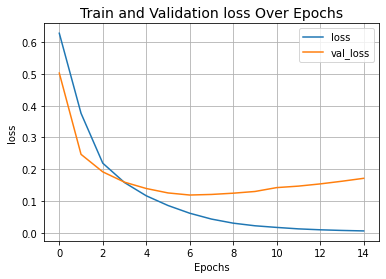

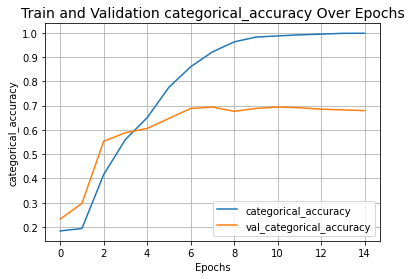

In [31]:
history = model.fit(X, y, validation_data=[X_val, y_val], batch_size = 128, epochs = 15, verbose = 1)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [32]:
_, categorical_acc = model.evaluate(X_test, y_test)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

11/11 [==============================] - 0s 3ms/step - loss: 0.1710 - categorical_accuracy: 0.7198
Categorical accuracy on the test set: 71.98%.
